In [1]:
import os
import numpy as np
import pandas as pd
import datetime as dt
from scipy.signal import savgol_filter
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('small')

In [36]:
!pip install siml
from siml.detect_peaks import *
from siml.signal_analysis_utils import *

  Preparing metadata (setup.py) ... done
  Created wheel for siml: filename=siml-0.4.0-py3-none-any.whl size=13710 sha256=c62d78b410ba94a218f2e4bf5a8e9fc7181864ee3487bfbf70b6616e0dab08c5
  Stored in directory: /root/.cache/pip/wheels/f1/49/60/7afebe00c09994ac2a01340ef8d06b77d1865b35cb29df43a0
Successfully built siml


# Load Data
In this notebook we will make use of the following dataset: [Air passengers dataset](https://www.kaggle.com/rakannimer/air-passengers)

In [2]:
import requests
from PIL import Image
from io import BytesIO

url = 'https://raw.githubusercontent.com/cockles98/ML_for_TimeSeries/master/data/air_passengers/AirPassengers.csv'
response = requests.get(url)

with open('air_passengers.csv', 'wb') as file:
    file.write(response.content)

In [3]:
df_air = pd.read_csv('air_passengers.csv', parse_dates=['Month'], date_parser=lambda x: pd.to_datetime(x, format='%Y-%m', errors = 'coerce'))
df_air = df_air.set_index('Month')

<ipython-input-3-b49496f8d7eb>:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_air = pd.read_csv('air_passengers.csv', parse_dates=['Month'], date_parser=lambda x: pd.to_datetime(x, format='%Y-%m', errors = 'coerce'))


In [6]:
df_air.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


### Let's see our datasets

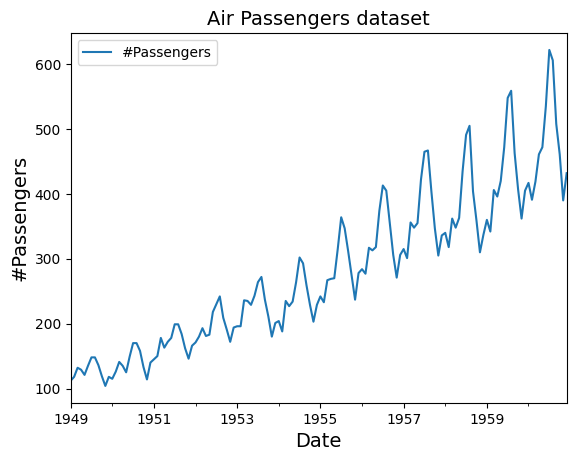

In [22]:
fig, axarr = plt.subplots()
df_air['#Passengers'].plot(kind='line')
plt.legend(loc='upper left')
plt.title('Air Passengers dataset', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('#Passengers', fontsize=14)
plt.show()

# Detrending the Air Passenger dataset

We have seen that we first need to detrend the dataset (or substract the average value) before we can apply the Fourier Transform. In this section we will see different methods for detrending a dataset and decomposing it into trend and seasonal components.

#### Detrending using stasmodels.seasonal_decompose()

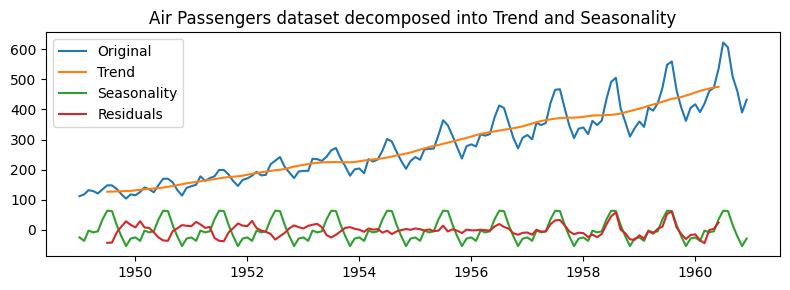

In [23]:
decomposition = seasonal_decompose(df_air)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, ax = plt.subplots(figsize=(8,3))
ax.plot(df_air, label='Original')
ax.plot(trend, label='Trend')
ax.plot(seasonal, label='Seasonality')
ax.plot(residual, label='Residuals')
ax.legend(loc='best')
ax.set_title('Air Passengers dataset decomposed into Trend and Seasonality')
plt.tight_layout()
plt.show()

#### Detrending using Scipy's savgol filter

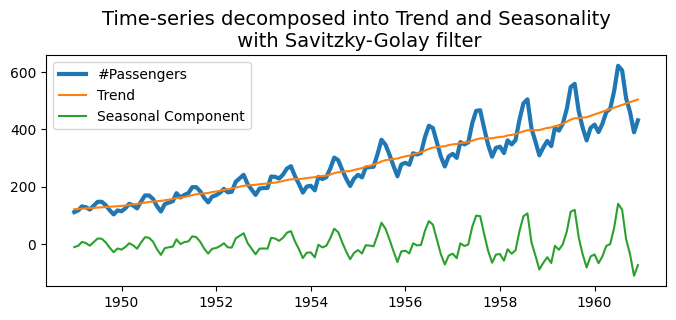

In [25]:
yvalues = df_air['#Passengers'].values
yvalues_trend = savgol_filter(yvalues,25,1)
yvalues_seasonal = yvalues-yvalues_trend

fig, ax = plt.subplots(figsize=(8,3))
ax.plot(df_air.index.values, yvalues, label='#Passengers',linewidth=3)
ax.plot(df_air.index.values, yvalues_trend, label='Trend')
ax.plot(df_air.index.values, yvalues_seasonal, label='Seasonal Component')
ax.legend()
ax.set_title('Time-series decomposed into Trend and Seasonality\n with Savitzky-Golay filter', fontsize=14)
plt.show()

#### Detrending using pandas rolling() functions

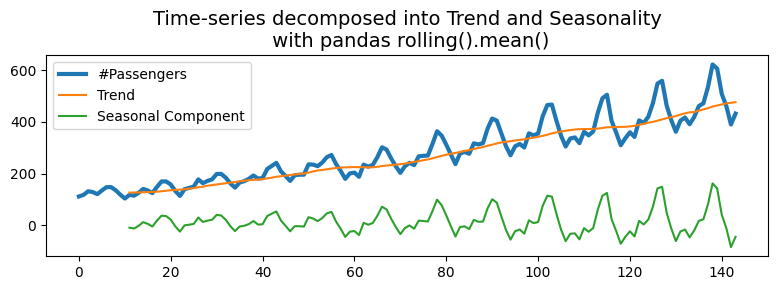

In [26]:
yvalues = df_air['#Passengers']
yvalues_trend = df_air['#Passengers'].rolling(window=12).mean()
yvalues_detrended = yvalues - yvalues_trend
xvalues = range(len(yvalues))

fig, ax = plt.subplots(figsize=(8,3))
ax.plot(xvalues, yvalues, label='#Passengers',linewidth=3)
ax.plot(xvalues, yvalues_trend, label='Trend')
ax.plot(xvalues, yvalues_detrended, label='Seasonal Component')
ax.legend()
ax.set_title('Time-series decomposed into Trend and Seasonality\n with pandas rolling().mean()', fontsize=14)
plt.tight_layout()
plt.show()

#### Detrending using numpy's polyfit()

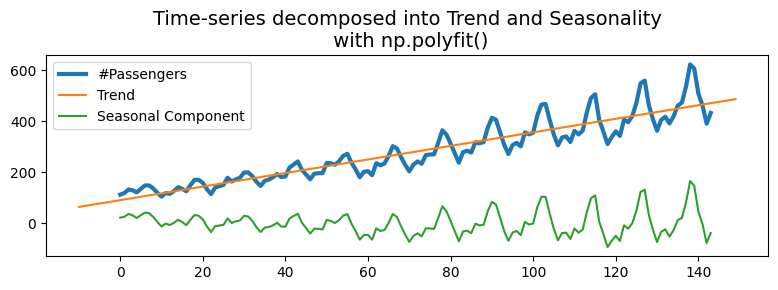

In [27]:
yvalues = df_air['#Passengers']
xvalues = range(len(yvalues))
xvalues_extended = range(-10,150)

z1 = np.polyfit(xvalues, yvalues, deg=1)
p1 = np.poly1d(z1)
yvalues_trend = p1(xvalues_extended)
yvalues_detrended = yvalues - p1(xvalues)

fig, ax = plt.subplots(figsize=(8,3))
ax.plot(xvalues, yvalues, label='#Passengers',linewidth=3)
ax.plot(xvalues_extended, yvalues_trend, label='Trend')
ax.plot(xvalues, yvalues_detrended, label='Seasonal Component')
ax.legend()
ax.set_title('Time-series decomposed into Trend and Seasonality\n with np.polyfit()', fontsize=14)
plt.tight_layout()
plt.show()

#### Detrending using only numpy matrix manipulations

Size of original time-series: 144 by 1
Size of reshaped array: 16 by 9
Size of reshaped array and averaged array: 16 by 1


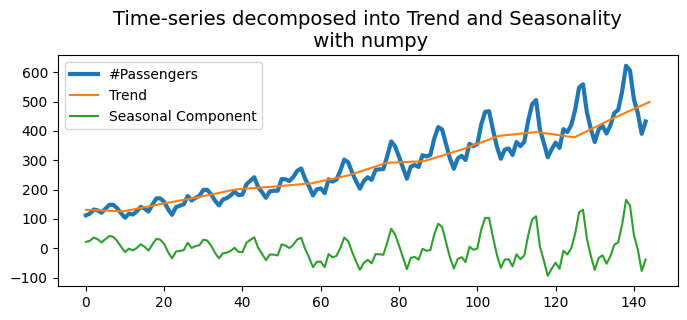

In [28]:
yvalues = df_air['#Passengers'].values
xvalues = range(len(yvalues))
yvalues_reshaped = yvalues.reshape(16,-1)
yvalues_mean = np.nanmean(yvalues_reshaped, axis=1)
xvalues_mean = np.linspace(0,len(yvalues),16)
print("Size of original time-series: {} by 1".format(*yvalues.shape))
print("Size of reshaped array: {} by {}".format(*yvalues_reshaped.shape))
print("Size of reshaped array and averaged array: {} by 1".format(*yvalues_mean.shape))

fig, ax = plt.subplots(figsize=(8,3))
ax.set_title('Time-series decomposed into Trend and Seasonality\n with numpy', fontsize=14)
ax.plot(xvalues, yvalues, label='#Passengers',linewidth=3)
ax.plot(xvalues_mean, yvalues_mean, label='Trend')
ax.plot(xvalues, yvalues_detrended, label='Seasonal Component')
ax.legend()
plt.show()

# Using the Fourier Transform to go from the time-domain to the frequency domain

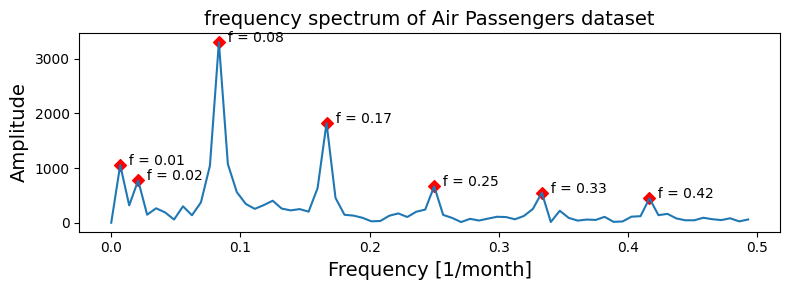

In [37]:
fraction_signal = 1.0
mph = 0.4
deg_polyfit= 1

yvalues = df_air['#Passengers'].values
fft_x, fft_y, p2 = construct_fft(yvalues, deg_polyfit)

indices_peaks = detect_peaks(fft_y, mph=430)

fig, ax = plt.subplots(figsize=(8,3))
ax.plot(fft_x, fft_y)
ax.scatter(fft_x[indices_peaks], fft_y[indices_peaks], color='red',marker='D')
ax.set_title('frequency spectrum of Air Passengers dataset', fontsize=14)
ax.set_ylabel('Amplitude', fontsize=14)
ax.set_xlabel('Frequency [1/month]', fontsize=14)
for idx in indices_peaks:
    x,y = fft_x[idx], fft_y[idx]
    text = "  f = {:.2f}".format(x,y)
    ax.annotate(text, (x,y))
plt.show()

# Reconstructing the Time-domain using np.fft.ifft()

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


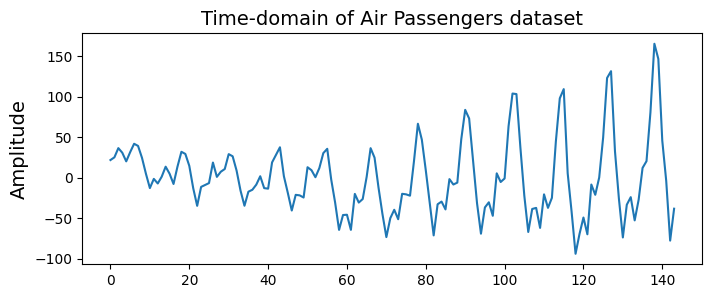

In [38]:
fft_y_  = np.fft.fft(yvalues_detrended)
inverse_fft = np.fft.ifft(fft_y_)

fig, ax = plt.subplots(figsize=(8,3))
ax.plot(inverse_fft, label='The inverse of the freq. spectrum')
ax.set_ylabel('Amplitude', fontsize=14)
ax.set_title('Time-domain of Air Passengers dataset', fontsize=14)
plt.show()

# Reconstructing the time-domain using np.fft.ifft() and parts of the frequency spectrum

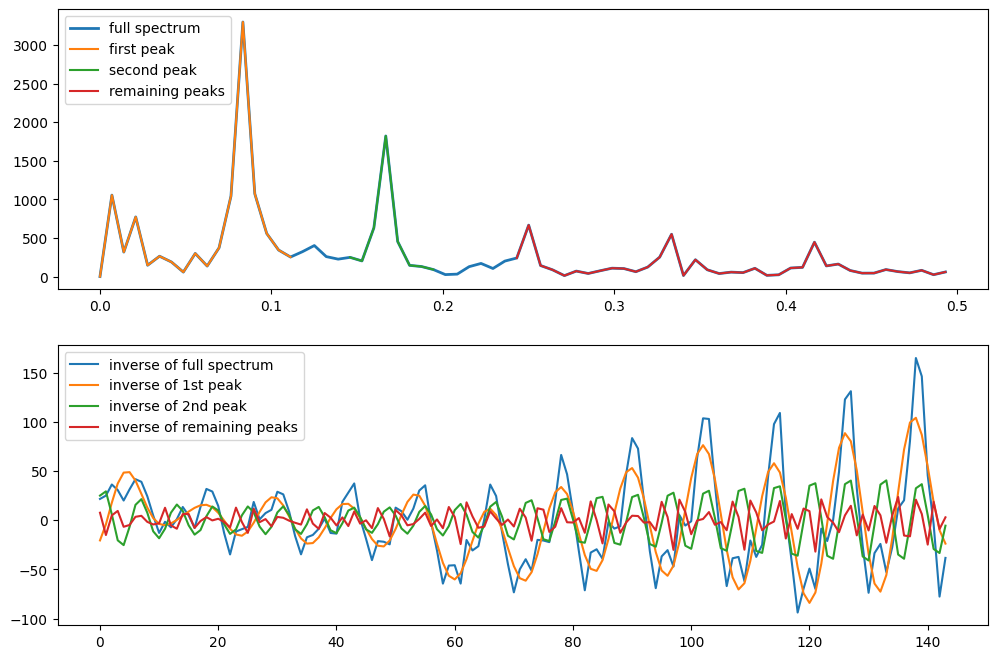

In [39]:
fig, axarr = plt.subplots(figsize=(12,8), nrows=2)
axarr[0].plot(fft_x, fft_y, linewidth=2, label='full spectrum')
axarr[0].plot(fft_x[:17], fft_y[:17], label='first peak')
axarr[0].plot(fft_x[21:29], fft_y[21:29], label='second peak')
axarr[0].plot(fft_x[35:], fft_y[35:], label='remaining peaks')
axarr[0].legend(loc='upper left')
fft_y_copy1 = fft_y_.copy()
fft_y_copy2 = fft_y_.copy()
fft_y_copy3 = fft_y_.copy()
fft_y_copy1[17:-17] = 0
fft_y_copy2[:21] = 0
fft_y_copy2[29:-29] = 0
fft_y_copy2[-21:] = 0
fft_y_copy3[:35] = 0
fft_y_copy3[-35:] = 0
inverse_fft = np.fft.ifft(fft_y_)
inverse_fft1 = np.fft.ifft(fft_y_copy1)
inverse_fft2 = np.fft.ifft(fft_y_copy2)
inverse_fft3 = np.fft.ifft(fft_y_copy3)
axarr[1].plot(inverse_fft, label='inverse of full spectrum')
axarr[1].plot(inverse_fft1, label='inverse of 1st peak')
axarr[1].plot(inverse_fft2, label='inverse of 2nd peak')
axarr[1].plot(inverse_fft3, label='inverse of remaining peaks')
axarr[1].legend(loc='upper left')
plt.show()

# Reconstructing the time-domain using our own function

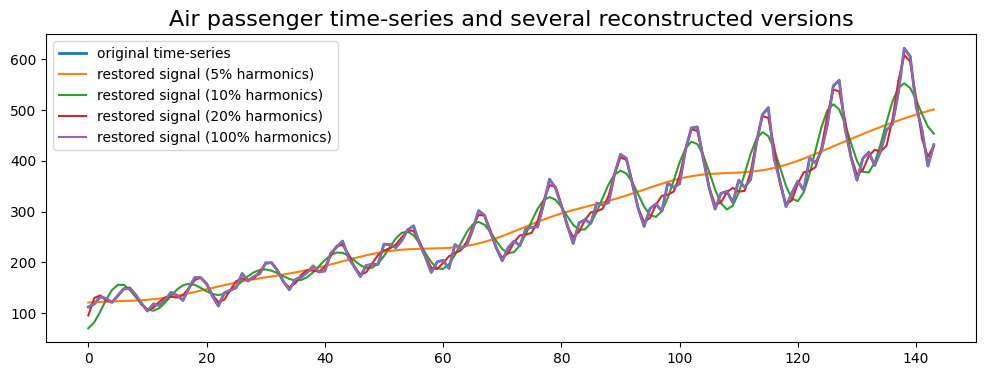

In [40]:
yvalues = df_air['#Passengers'].values
xvalues = np.arange(len(yvalues))
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(yvalues, linewidth=2, label='original time-series')

list_frac_harmonics = [0.05, 0.1, 0.2, 1.0]
for ii, frac_harmonic in enumerate(list_frac_harmonics):
    yvalues_restored = reconstruct_from_fft(yvalues, frac_harmonics=frac_harmonic)
    label = 'restored signal ({:.0f}% harmonics)'.format(100*frac_harmonic)
    ax.plot(yvalues_restored, label=label)
ax.legend(loc='upper left')
ax.set_title('Air passenger time-series and several reconstructed versions', fontsize=16)
plt.show()